In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import h5py
import copy

import amici
from petab.C import *
import petab
import petab.C
import pypesto
import pypesto.petab
from pypesto.optimize import minimize
from pypesto.startpoint import uniform
from pypesto.engine import MultiProcessEngine, MultiThreadEngine
from pypesto.optimize.optimizer import FidesOptimizer
import pypesto.optimize as optimize

from pypesto.visualize import waterfall
from pypesto.visualize import parameters
from pypesto.visualize.model_fit import visualize_optimized_model_fit
from pypesto.visualize import profiles

import pypesto.profile as profile
from pypesto.optimize import ScipyOptimizer
from pypesto.profile.options import ProfileOptions

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

In [2]:
def hex_to_rgba_gradient(color1, color2, n):
    '''
    Create a gradient in rgba between two hex colors
    '''
    # Convert to rgba
    c1 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color1))
    c2 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color2))

    return [[(c1[i]*(n-j-1) + c2[i]*j)/(n-1) for i in range(4)] for j in range(n)]

# find the index for cut off based on Chi square distribution CI 95%
def find_cut_off_index(result, ci = 0.95):
    '''
    Find the cut off index for the data based on the Chi square distribution
    '''

    # calculate the chi square distribution
    cut_off_value = scipy.stats.chi2.ppf(ci, 1)

    # find the index
    best_fval = result.optimize_result.list[0].fval

    for i in range(len(result.optimize_result.list)):
        if result.optimize_result.list[i].fval > best_fval + cut_off_value:
            break
    
    return i - 1

def find_cut_off_x_trace(result, ci = 0.95, flatten = True):

    cut_off_value = scipy.stats.chi2.ppf(ci, 1)
    best_fval = result.optimize_result.list[0].fval

    # store the optimized x trace that are below the cut off value
    x_trace_within_cut_off = []
    if flatten:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off.append(x_trace[j])
    else:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            x_trace_within_cut_off_i = []
            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off_i.append(x_trace[j])
            x_trace_within_cut_off.append(x_trace_within_cut_off_i)

    return x_trace_within_cut_off

In [3]:
# Plot setting
plt.rcParams['font.size'] = 30

dpi = 100
wid = int(2560/dpi)
hei = int(1600/dpi)

In [4]:
# number of optimization runs
n_runs = 5000

In [5]:
# Define the folder where you want to save the figures
folder_path = "/Users/yuhongliu/Documents/OV/figures/second_model_dynamics_test3/n"+str(n_runs)+"/"

# If the folder does not exist, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# optimization
hierarchical = True

petab_yaml = 'petab_files/reduced_measurements.yaml'
petab.validate(petab_yaml)
petab_problem = petab.Problem.from_yaml(petab_yaml)

np.random.seed(500)

problem = pypesto.petab.PetabImporter(
        petab_problem,
        hierarchical=hierarchical,
        model_name=f"REDUCED_MEASUREMENTS",
    ).create_problem(force_compile=True)

problem.objective.amici_model.setAllStatesNonNegative()

# some model properties
print("Model parameters:", list(problem.objective.amici_model.getParameterIds()), "\n")
print("Model const parameters:", list(problem.objective.amici_model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(problem.objective.amici_model.getObservableIds()), "\n")
print("Model states:    ", list(problem.objective.amici_model.getStateIds()), "\n")

Compiling amici model to folder /Users/yuhongliu/Documents/OV/models/second_model_dynamics_test3/amici_models/0.26.1/REDUCED_MEASUREMENTS.
2024-09-23 10:50:43.647 - amici.petab.sbml_import - INFO - Importing model ...
2024-09-23 10:50:43.648 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
2024-09-23 10:50:43.653 - amici.petab.sbml_import - INFO - Model name is 'REDUCED_MEASUREMENTS'.
Writing model code to '/Users/yuhongliu/Documents/OV/models/second_model_dynamics_test3/amici_models/0.26.1/REDUCED_MEASUREMENTS'.
2024-09-23 10:50:43.654 - amici.petab.sbml_import - INFO - Species: 0
2024-09-23 10:50:43.654 - amici.petab.sbml_import - INFO - Global parameters: 12
2024-09-23 10:50:43.654 - amici.petab.sbml_import - INFO - Reactions: 0
2024-09-23 10:50:43.669 - amici.petab.sbml_import - INFO - Observables: 1
2024-09-23 10:50:43.670 - amici.petab.sbml_import - INFO - Sigmas: 1
2024-09-23 10:50:43.670 - amici.petab.sbml_import - DEBUG - Adding output parameters to model: ['obs

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/yuhongliu/Documents/OV/models/second_model_dynamics_test3/amici_models/0.26.1/REDUCED_MEASUREMENTS -B /Users/yuhongliu/Documents/OV/models/second_model_dynamics_test3/amici_models/0.26.1/REDUCED_MEASUREMENTS/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/opt/homebrew/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/yuhongliu/Documents/OV/models/second_model_dynamics_test3/amici_models/0.26.1/REDUCED_MEASUREMENTS/REDUCED_MEASUREMENTS -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/opt/homebrew/lib/python3.12/site-packages/amici/lib/cmake/SuiteSparse;/opt/homebrew/lib/python3.12/site-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/opt/homebrew/lib/python3.12/site-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/opt/homebrew/opt/python@3.12/bin/python3.12

==> Building:
$ cmake --build

2024-09-23 10:50:55.959 - amici.petab.sbml_import - INFO - Finished Importing PEtab model            (1.23E+01s)


Model parameters: ['rho', 'kappa', 'psi', 'phi', 'beta', 'delta', 'observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol'] 

Model const parameters: ['virus_injection'] 

Model outputs:    ['tumor_vol'] 

Model states:     ['C_u', 'C_i', 'C_l', 'V'] 



In [6]:
loading = True

if loading:
    # load result history from file
    result = pypesto.store.read_result('optimization_history/n'+ str(n_runs) +'.hdf5')

else:
    # optimize the model
    result = minimize(
        problem=problem,
        optimizer=FidesOptimizer(verbose=False, options={'maxiter': 5000}),
        n_starts=n_runs,
        engine=MultiProcessEngine(),
        # startpoint_method=uniform,
        history_options = pypesto.HistoryOptions(trace_record=True, storage_file='optimization_history/n'+ str(n_runs) +'.hdf5'),
        filename='optimization_history/n'+ str(n_runs) +'.hdf5',
    )

# print result summary
print(result.summary())

Loading the profiling result failed. It is highly likely that no profiling result exists within optimization_history/n5000.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within optimization_history/n5000.hdf5.


## Optimization Result 

* number of starts: 5000 
* best value: 73.42038209461641, id=1710
* worst value: inf, id=999
* number of non-finite values: 3775

* execution time summary:
	* Mean execution time: 0.248s
	* Maximum execution time: 10.848s,	id=1534
	* Minimum execution time: 0.008s,	id=4402
* summary of optimizer messages:

  |   Count | Message                                                     |
  |--------:|:------------------------------------------------------------|
  |    3775 | Encountered non-finite function inf value at initial point. |
  |    1057 | Converged according to fval difference                      |
  |      95 | Trust Region Radius too small to proceed                    |
  |      73 | Converged according to gradient norm                        |

* best value found (approximately) 187 time(s)
* number of plateaus found: 14

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=False options=

In [7]:
parameters_from_result = dict(zip(problem.x_names, result.optimize_result.list[0]['x']))

In [8]:
# Scale all parameters and put them into a dictionary
scaled_parameters = {key: 10**value for key, value in parameters_from_result.items()}

# Print the scaled parameters
print("Scaled parameters:")
for key, value in scaled_parameters.items():
    print(f"{key}: {value}")

Scaled parameters:
rho: 6.688227896589945
kappa: 0.0021605706396215373
psi: 0.7403458924791038
phi: 1.163594897693138
beta: 0.2565020587330166
delta: 0.0019389685109793865


# Obtain data and visualize the fitting result

In [9]:
return_dict = problem.objective(result.optimize_result.list[0].x, return_dict=True)
rdatas = return_dict['rdatas']
edatas = problem.objective.edatas
x_axis = [edata.id for edata in edatas]
simulation = [rdata.y.reshape(5, -1)[:,0] for rdata in rdatas]
data = [np.array(edata.getObservedData()).reshape(5, -1) for edata in edatas]

IndexError: index 1 is out of bounds for axis 1 with size 1

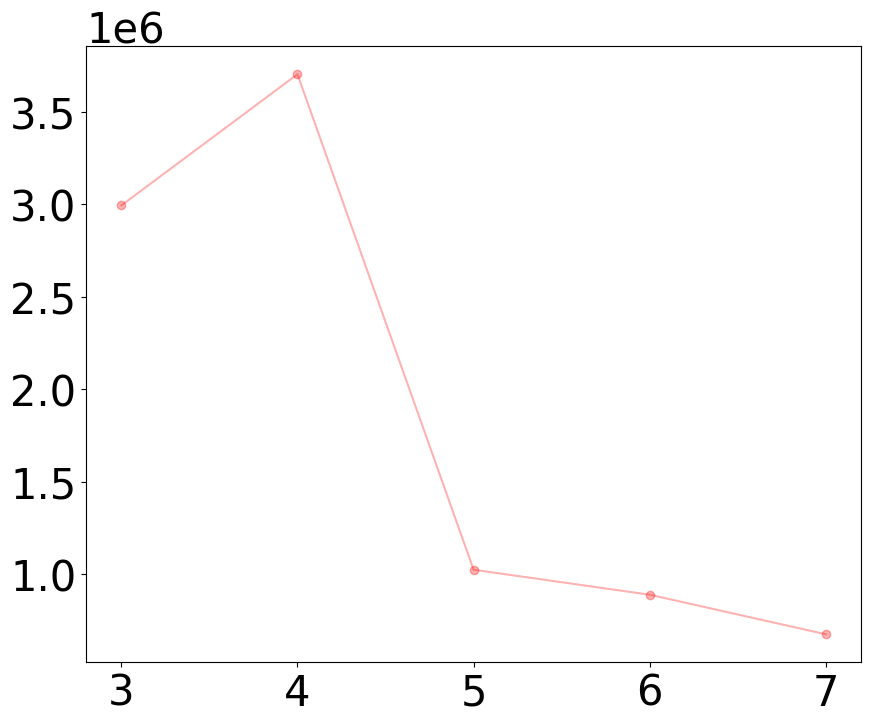

In [10]:
# visualize the fitting result by comparing the simulation and the data
# separate into vvDD and ctrl with two subplots

# plot the ctrl data and simulation, simulation[0] (1d array) and data[0] 
# (2d array as it has 5 timepoints [3,4,5,6,7] and 10 samples)
# plt.figure(figsize=(10, 8))
# for i in range(10):
#     plt.plot(np.array([3,4,5,6,7]), data[0][:, i], 
#              marker='o', linestyle='-', color='red', alpha=0.3, label='data' if i == 0 else "")
# plt.plot(np.array([3,4,5,6,7]), simulation[0], 
#          marker='*', linestyle='-', color='red', alpha=1, label='simulation')
# plt.xlabel('Time (days)')
# plt.ylabel('Tumor Volume ($mu m^3$)')
# plt.title('Tumor Volume vs Time for PBS Conditions')
# plt.legend()
# plt.grid(False)
# plt.xticks([3, 4, 5, 6, 7])
# plt.tight_layout()
# plt.savefig(folder_path + 'ctrl_fit.pdf', dpi=300, bbox_inches='tight')
# plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_73121/4283468257.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Tumor Volume ($\mu m^3$)')


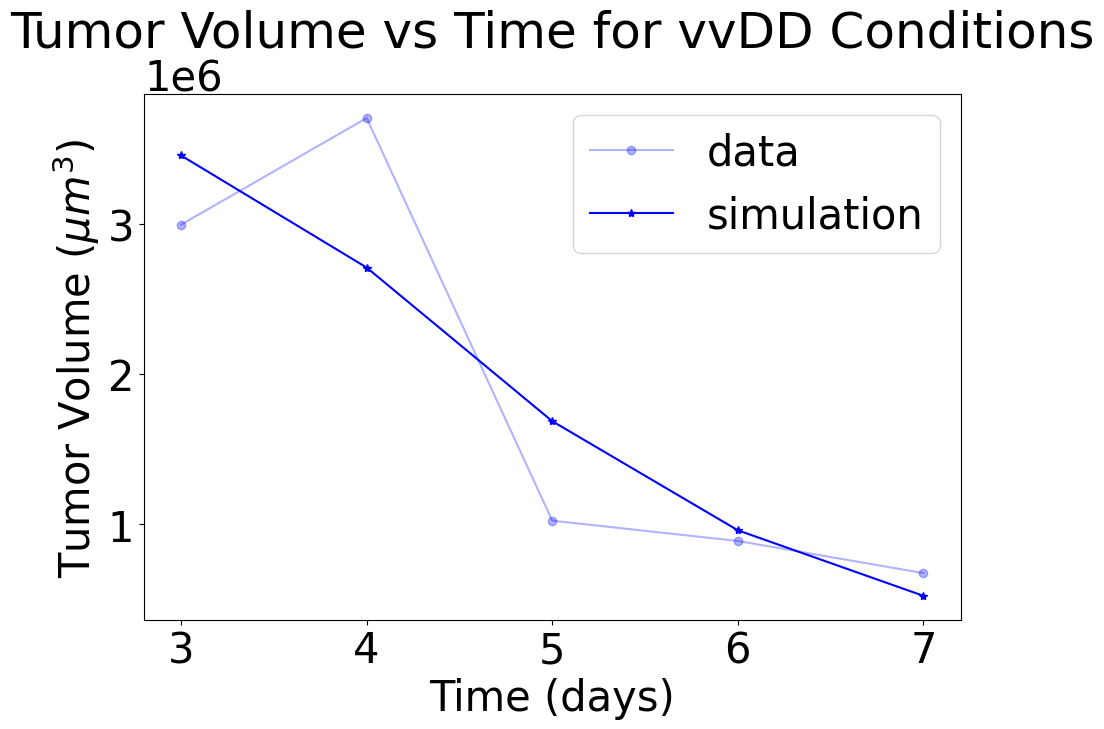

In [11]:
# plot the vvDD data and simulation, simulation[1] (1d array) and data[1] 
# (2d array as it has 5 timepoints [3,4,5,6,7] and 10 samples)
plt.figure(figsize=(10, 8))
for i in range(1):
    plt.plot(np.array([3,4,5,6,7]), data[0][:, i], 
             marker='o', linestyle='-', color='blue', alpha=0.3, label='data' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation')
plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)')
plt.title('Tumor Volume vs Time for vvDD Conditions')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.tight_layout()
plt.savefig(folder_path + 'vvDD_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))

for i in range(10):
    plt.plot(np.array([3,4,5,6,7]), data[0][:, i], 
             marker='o', linestyle='-', color='red', alpha=0.3, label='data - ctrl' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='red', alpha=1, label='simulation - ctrl')

for i in range(1):
    plt.plot(np.array([3,4,5,6,7]), data[1][:, i], 
             marker='o', linestyle='-', color='blue', alpha=0.3, label='data - vvDD' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[1], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation - vvDD')

plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)')
plt.title('Tumor Volume vs Time for vvDD Conditions')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.savefig(folder_path + 'ctrl_vvDD_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# calculate the mean and std of the data within ctrl and vvDD groups and compare again with the simulation

# Calculate mean and standard error for vvDD
vvDD_mean = data[1].mean(axis=1)
vvDD_se = data[1].std(axis=1)
# Calculate mean and standard error for PBS
pbs_mean = data[0].mean(axis=1)
pbs_se = data[0].std(axis=1)

# Plot both provided and calculated data
plt.figure(figsize=(12, 8))
# Plot provided data
plt.errorbar(np.array([3,4,5,6,7]), vvDD_mean, 
             yerr=[vvDD_mean - vvDD_se],
             fmt='o--', color='blue', alpha=0.3, ecolor='lightblue', capsize=5, label='data - vvDD')
plt.errorbar(np.array([3,4,5,6,7]), pbs_mean, 
             yerr=[pbs_mean - pbs_se],
             fmt='o--', color='red', alpha=0.3, ecolor='lightcoral', capsize=5, label='data - ctrl')
# Plot simulated data
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='red', alpha=1, label='simulation - ctrl')
plt.plot(np.array([3,4,5,6,7]), simulation[1], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation - vvDD')

plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu$ $m^3$)') 
plt.title('Mean Tumor Volume with Standard Deviation vs Time')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.savefig(folder_path + 'mean_tumor_volume_with_std.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Visualize Temporal Dynamics

In [ ]:
"""
the C_u, C_i, V dynamics before the injection of virus
for both ctrl and vvDD conditions
"""

import numpy as np

def C_u(t, 
       kappa = scaled_parameters['kappa'],
       rho = scaled_parameters['rho'],
       Cu_0 = 400.):
    # return the value of C_u at time t
    return 1/(kappa + np.exp(-rho*t)*(1/Cu_0 - kappa))

def C_i(t):
    # t has to be between 0 and 1
    # raise error if t is not in the range
    if t.any() < 0 or t.any() > 1:
        raise ValueError("t has to be between 0 and 1")
    # return the value of C_i at time t
    return np.zeros_like(t)

def V(t):
    # t has to be between 0 and 1
    if t.any() < 0 or t.any() > 1:
        raise ValueError("t has to be between 0 and 1")
    # return the value of V at time t
    return np.zeros_like(t)

In [ ]:
"""
visualize the temporal dynamics of the virus, uninfected and infected tumor cells using the fitted model from the result
from day 3 to day 13
get the simulation results for the optimized parameters
"""

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

amici_model = problem.objective.amici_model

species_to_plot = ['C_u', 'C_i', 'V']

# simulate from day 3 to day 12
stop_day = 10
timepoints = np.linspace(start=0, stop=stop_day, num=50)

simulation_rdatas = _get_simulation_rdatas(
    result=result,
    problem=problem,
    start_index = 0,
    simulation_timepoints=timepoints,
)

# Plot all state trajectories
for c_ in range(len(problem.objective.edatas)):
    for species in species_to_plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        label = f"{species} - {problem.objective.edatas[c_].id}"
        if problem.objective.edatas[c_].id == 'ctrl':
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='red', label=label, lw = 3)
        else:
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='blue', label=label, lw = 3)
        ax.set_ylabel(species)
        ax.set_xlabel('Time (days)')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"State {species} over time")
        # Change x-axis range and labels
        ax.set_xticks(np.arange(0, stop_day, 1))
        ax.set_xticklabels(np.arange(3, stop_day+3, 1))
        plt.xticks(rotation=60)
        plt.savefig(folder_path + f"{species}_over_time.pdf", dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
"""
visualize the temporal dynamics of the virus, uninfected and infected tumor cells using the fitted model from the result
from day 2 to day 13
"""

# obtain the dynamics of C_u, C_i, V over time
timepoints_previous = np.linspace(start=0, stop=1, num=100)
C_u_previous = C_u(timepoints_previous)
C_i_previous = C_i(timepoints_previous)
V_previous = V(timepoints_previous)

C_u_ctrl_whole = C_u(np.concatenate([timepoints_previous, timepoints+1]))

# adjust all state trajectories with previous dynamics
for c_ in range(len(problem.objective.edatas)):
    for species in species_to_plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        label = f"{species} - {problem.objective.edatas[c_].id}"
        if problem.objective.edatas[c_].id == 'ctrl':
            ax.plot(timepoints + 1, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='red', label=label, lw = 3)
            if species == 'C_u':
                ax.plot(timepoints_previous, C_u_previous, color='red', lw = 3)
                ax.plot(np.concatenate([timepoints_previous, timepoints+1]), C_u_ctrl_whole, '--', color='purple', label='C_u - ctrl (analytical)', lw = 3)
            elif species == 'C_i':
                ax.plot(timepoints_previous, C_i_previous, color='red', lw = 3)
            elif species == 'V':
                ax.plot(timepoints_previous, V_previous, color='red', lw = 3)
        else:
            ax.plot(timepoints + 1, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='blue', label=label, lw = 3)
            if species == 'C_u':
                ax.plot(timepoints_previous, C_u_previous, color='blue', lw = 3)
            elif species == 'C_i':
                ax.plot(timepoints_previous, C_i_previous, color='blue', lw = 3)
            elif species == 'V':
                ax.plot(timepoints_previous, V_previous, color='blue', lw = 3)
        
        ax.set_ylabel(species)
        ax.set_xlabel('Time (days)')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"State {species} over time")
        # Change x-axis range and labels
        ax.set_xticks(np.arange(0, stop_day+1, 1))
        ax.set_xticklabels(np.arange(2, stop_day+3, 1))
        # rotate the x-axis labels
        plt.xticks(rotation=60)
        
        plt.savefig(folder_path + f"{species}_over_time_adjusted.pdf", dpi=300, bbox_inches='tight')
        plt.show()

# Parameter estimation analysis

In [ ]:
# get the statistics for 95% CI
cut_off_index = find_cut_off_index(result)
x_trace_within_cut_off = np.array(find_cut_off_x_trace(result, ci = 0.95))
x_trace_within_cut_off_df = pd.DataFrame(x_trace_within_cut_off, columns=problem.x_names)

x_trace_within_cut_off_NF = find_cut_off_x_trace(result, ci = 0.95, flatten=False)
x_trace_within_cut_off_NF_top100 = x_trace_within_cut_off_NF[:100]

# unpack and reshape x_trace_within_cut_off_NF_top100 into an array with the same column number as x_trace_within_cut
x_trace_within_cut_off_NF_top100_unpacked = []
for i in range(len(x_trace_within_cut_off_NF_top100)):
    for j in range(len(x_trace_within_cut_off_NF_top100[i])):
        x_trace_within_cut_off_NF_top100_unpacked.append(x_trace_within_cut_off_NF_top100[i][j])

x_trace_within_cut_off_NF_top100_unpacked_df = pd.DataFrame(x_trace_within_cut_off_NF_top100_unpacked, columns=problem.x_names)

In [ ]:
plt.rcParams.update({'font.size': 30})

waterfall(result, size=(wid, hei))
plt.savefig(os.path.join(folder_path, 'waterfall_plot.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

In [ ]:
pypesto.visualize.optimizer_history(result)
plt.savefig(os.path.join(folder_path, 'optimizer_history_plot.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 3, figsize=(wid, hei), sharey=False, )

pypesto.visualize.parameters(result, ax = axs[0], plot_inner_parameters=False, start_indices=cut_off_index,  colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', cut_off_index))
pypesto.visualize.parameters(result, ax = axs[1], plot_inner_parameters=False, start_indices=300,  colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', 300))
pypesto.visualize.parameters(result, ax = axs[2], plot_inner_parameters=False, start_indices=100,  colors=hex_to_rgba_gradient('#A7C9F8', '#28518B', 100))

axs[0].set_title('95% CI', fontsize=30)
axs[1].set_title('Top 300', fontsize=30)
axs[2].set_title('Top 100', fontsize=30)

# set all the x axis, x and y labels to have fontsize 30
for j in range(3):
    axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=20)
    axs[j].set_xlabel('Parameter Value', fontsize=30)
    axs[j].set_ylabel('Parameter', fontsize=30)

plt.suptitle('Parameter Estimation', fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'parameters_plot.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

In [ ]:
pypesto.visualize.optimization_scatter(result, start_indices=cut_off_index, size=(wid, hei))
plt.savefig(os.path.join(folder_path, 'parameters_scatter_plot_cut_off_'+str(cut_off_index)+'.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

# Profiling

In [ ]:
result = profile.parameter_profile(
    problem=problem,
    result=result,
    engine=MultiProcessEngine(),
    optimizer=ScipyOptimizer(),
    profile_options=ProfileOptions(whole_path=True),
    overwrite=True,
    filename='optimization_history/n5000.hdf5',
)

In [ ]:
profiles(result, show_bounds=True, size=(wid, hei))
plt.savefig(os.path.join(folder_path, 'profile_whole_path_plot.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

# Sampling

In [ ]:
# sampling
sampler = pypesto.sample.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.sample.AdaptiveMetropolisSampler(), n_chains=5
    )
sampling_n = 10000
result = pypesto.sample.sample(
    problem,
    n_samples=sampling_n,
    sampler=sampler,
    result=result,
    filename='optimization_history/n5000.hdf5',
)

In [ ]:
ax = pypesto.visualize.sampling_parameter_traces(
    result,
    use_problem_bounds=False,
    size=(wid, hei),
)
plt.savefig(os.path.join(folder_path, 'params_traceplot_sampling'+str(sampling_n)+'.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

pypesto.visualize.sampling_1d_marginals(result, size=(wid, hei))
plt.savefig(os.path.join(folder_path, 'params_marginalplot_sampling'+str(sampling_n)+'.pdf'), dpi=dpi, bbox_inches="tight")
plt.show()

In [ ]:
# the problem is that the release of virus is too fast, and the peak value is
# QUESTION: but how to contraint it properly? based on just the data, all the simulation is within the error bar

# TODO: update overleaf documentation
# TODO: organize the notes in all papers
# TODO: Notion goals organzing

# TODO: mixed effects model exploration